# Experiment Environment for TOM and TOM-ON

## Libraries

In [39]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
#from scipy.stats.kde import gaussian_kde
from sklearn.neighbors import KernelDensity
import scipy.stats as stats
from sklearn.cluster import KMeans
from ipywidgets import IntProgress
from IPython.display import display
from sklearn.utils import shuffle
import math

### Generate Data

In [10]:
def get_data(pos_mu=8, neg_mu=3, pos_size=2000, unl_size=2000, alpha=0.5):
    rng = np.random.default_rng()
    
    pos_data = rng.normal(loc=pos_mu, size=pos_size)
    pos_unl_data = rng.normal(loc=pos_mu, size=int(alpha*unl_size))
    neg_unl_data = rng.normal(loc=neg_mu, size=int((1-alpha)*unl_size))
    unl_data = np.concatenate((pos_unl_data,neg_unl_data))
    
    pos_labels = np.zeros_like(pos_data)
    unl_labels = np.ones_like(unl_data)
    
    X=np.concatenate((pos_data,unl_data)).reshape((-1, 1))
    y=np.concatenate((pos_labels,unl_labels))
    
    p = np.random.permutation(len(X))
    X,y = X[p], y[p]
    
    p2 = np.random.permutation(len(unl_data))
    unl_data = unl_data[p2]
    
    
    return X,y, pos_data, unl_data

### Train Non-Traditional Classifier

In [11]:
def train_NTC(X,y):
    clf = LogisticRegression(random_state=0).fit(X, y)
    
    return clf

### My MPE Method

In [12]:
def my_method(pos_probs, unl_probs):
    
    loEstimates = []
    
    opt_thresh, thresholds, lop, lou, difs, squared_difs = find_optimal_thresh(pos_probs, unl_probs, gran=101)
    
    p_count = 1 # Initialize to 1 to avoid div by 0
    n_count = 1
    
    for prob in unl_probs:
        if prob > opt_thresh:
            p_count+=1
        else:
            n_count+=1
            
        alpha_estimate = (p_count)/(p_count+n_count)
        loEstimates.append(alpha_estimate)
    
    if len(loEstimates)>0:
        final_estimate = loEstimates[-1]
    else:
        final_estimate = 0.5
        
    return final_estimate, loEstimates, opt_thresh, thresholds, lop, lou, difs, squared_difs

### Get Probabilities to Feed to my_method

In [36]:
def get_probs(clf, pos_data, unl_data):
    
    pos_probs = []
    unl_probs = []
    
    for point in pos_data:
        prob = clf.predict_proba([[point]])[0][0]
        pos_probs.append(prob)
    
    for point in unl_data:
        prob = clf.predict_proba([[point]])[0][0]
        unl_probs.append(prob)
        
    return pos_probs, unl_probs

### Find Optimal Threshold to use in NTC for MPE

In [14]:
def find_optimal_thresh(pos_probs, unl_probs, gran=101):
    
    pos_probs = np.array(pos_probs)
    unl_probs = np.array(unl_probs)

    thresholds = np.linspace(0,1,gran)

    lop = []
    lou = []
    difs = []
    squared_difs = []
    
    for t in thresholds:
        #pos_above = len(pos_probs[pos_probs > t]) # Expensive! (O(n)) Could possibly use a finite number of bins to get around this
        #unl_above = len(unl_probs[unl_probs > t])
        
        pos_above = len(pos_probs[pos_probs > t])/len(pos_probs)
        unl_above = len(unl_probs[unl_probs > t])/len(unl_probs)

        lop.append(pos_above)
        lou.append(unl_above)
        difs.append(abs(pos_above-unl_above))
        squared_difs.append(((pos_above-unl_above)**2))
    
    max_dif_idx = np.argmax(difs)
    opt_thresh = thresholds[max_dif_idx]
    
    return opt_thresh, thresholds, lop, lou, difs, squared_difs

### Plotting

In [100]:
def plot_MPE(lor, true_alpha):
    plt.plot(lor, 'r', label = "Estimate")
    plt.plot(true_alpha*np.ones_like(lor), "--k",label=f"true alpha: {true_alpha}")
    plt.xlabel("num unlabeled samples")
    plt.ylabel("estimated alpha")
    plt.title("NTC Based MPE using TOM-ON")
    ax = plt.gca()
    ax.annotate(f'Alpha Estimate: {lor[-1]}', xy = (len(lor),lor[-1]),xytext=(1.05, 0.75),\
                textcoords='axes fraction',arrowprops=dict(facecolor='black', shrink=0.0))
    plt.legend()

In [16]:
def plot_probs(unl_probs, pos_probs, actual_thresh, opt_thresh=None):
    plt.hist(unl_probs,alpha=0.5, bins= np.linspace(0,1,21),color='orange',label="unl probs",edgecolor='black')
    plt.hist(pos_probs,alpha=0.5, bins= np.linspace(0,1,21),label="pos probs",edgecolor='black')
    
    plt.axvline(actual_thresh, color='k', linestyle='dashed', linewidth=2, label = "actual thresh")
    if opt_thresh != None:
        plt.axvline(opt_thresh, color='g', linestyle='dashed', linewidth=2, label = "optimal thresh")
    plt.title("Probabilities")
    plt.ylabel("Num Samples")
    
    plt.legend()

In [17]:
def probs_above_plot(thresholds, lop, lou, actual_thresh, opt_thresh=None):
    plt.plot(thresholds, lop, "-g", label='pos probs above thresh')
    plt.plot(thresholds, lou, "-k", label='unl probs above thresh')
    
    plt.axvline(actual_thresh, color='k', linestyle='dashed', linewidth=2, label = "actual thresh")
    if opt_thresh != None:
        plt.axvline(opt_thresh, color='g', linestyle='dashed', linewidth=2, label = "optimal thresh")
        
    plt.xlabel('Threshold')
    plt.ylabel("% Probs Above Thresh")
    plt.title("% Probs Above Thresh")
    plt.legend()

In [18]:
def dif_plot(thresholds, difs, actual_thresh, opt_thresh=None):
    plt.plot(thresholds,difs,label="diffs")
    
    
    plt.axvline(actual_thresh, color='k', linestyle='dashed', linewidth=2, label = "actual thresh")
    if opt_thresh != None:
        plt.axvline(opt_thresh, color='g', linestyle='dashed', linewidth=2, label = "optimal thresh")
    
    plt.xlabel("thresh")
    plt.ylabel("pos_above - unl_above")
    plt.title("pos_above - unl_above")
    plt.legend()

In [19]:
def kde_plot(onl_pos_data, onl_unl_data):
    X = np.linspace(-4, 15, 1000)

    pos_kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
    unl_kde = KernelDensity(bandwidth=0.2, kernel='gaussian')

    onl_pos_data = np.array(onl_pos_data)
    onl_unl_data = np.array(onl_unl_data)

    pos_kde.fit(onl_pos_data.reshape(-1,1))
    unl_kde.fit(onl_unl_data.reshape(-1,1))

    X = X.reshape(-1,1)

    pos_logprob = pos_kde.score_samples(X)
    unl_logprob = unl_kde.score_samples(X)

    plt.plot(X, np.exp(pos_logprob), label="pos kde")
    plt.plot(X, np.exp(unl_logprob), label="unl kde")
    #plt.plot(X, stats.norm.pdf(X,neg_mu,1), label="true neg")
    #plt.plot(X, stats.norm.pdf(X,pos_mu,1), label="true pos")
    plt.legend()
    plt.title("Estimated PDFs")

In [77]:
def plot_thresh(loThresh):
    plt.plot(loThresh, label="threshold",marker='o',markersize=3,color="orange")
    plt.title("Threshold per Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Threshold")

### Experiment Script

In [20]:
def experiment_single(pos_mu = 8, neg_mu = 3, total_size = 4000, beta = 0.5, alpha=0.5, plot = True):
    
    pos_size = int(beta*total_size)
    unl_size = int(total_size - pos_size)
    
    X_train, y_train ,_,_ = get_data(pos_mu=pos_mu, neg_mu=neg_mu, pos_size=pos_size, unl_size=unl_size, alpha=alpha)
    
    clf = train_NTC(X_train, y_train)
    
    _, _, pos_test, unl_test = get_data(pos_mu=pos_mu, neg_mu=neg_mu, pos_size=pos_size, unl_size=unl_size, alpha=alpha)
    
    pos_probs, unl_probs = get_probs(clf, pos_test, unl_test)
    
    final_estimate, loEstimates, optimal_thresh, thresholds,lop, lou, difs, squared_difs = my_method(pos_probs, unl_probs)
    
    if plot == True:
        plot_MPE(loEstimates, alpha)
        plt.show()
        plot_probs(unl_probs, pos_probs, optimal_thresh)
        plt.show()
        probs_above_plot(thresholds, lop, lou, optimal_thresh, opt_thresh=None)
        plt.show()
        dif_plot(thresholds, difs,optimal_thresh)
        plt.show()
        kde_plot(pos_test, unl_test)
        plt.show()

### experiment_single
#### Bugs:
- Haven't found any yet...

#### ToDo:


#### Parameters:
- alpha $\in [0,1]$ | default: 0.5
    - The mixture proportion of the unlabeled samples
    - Ex. If alpha = 0.4, 40% of the unlabeled samples will be positive and the rest will be negative
- pos_mu $\in \mathbb{R}$ | default: 8
    - The mean of the positive data
- neg_mu $\in \mathbb{R}$ | default: 3
    - The mean of the negative data
- total_size $\in \mathbb{Z}$ | default: 4000
    - The number of samples
- beta $\in [0,1]$ | default: 0.5
    - Determines the postive vs unlabeled split.The number of unlabeled samples
    - Ex. If beta = 0.4, then 40 percent of the smaples will be positive and 60 percent will be unlabeled
- alpha $\in [0,1]$ | default: 0.5
    - determines mixture proportion of the unlabeled samples
    - Ex. If alpha = 0.4, then 40% will be positive and 60% will be negative
- plot | default: True
    - If true, will plot information. Otherwise, no plotting.

#### Returns:
- Nothing

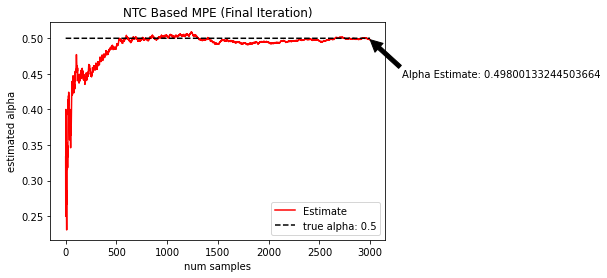

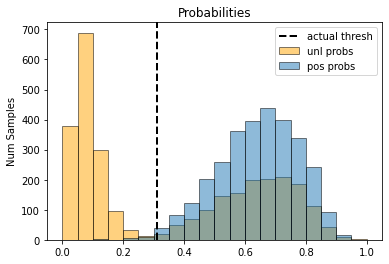

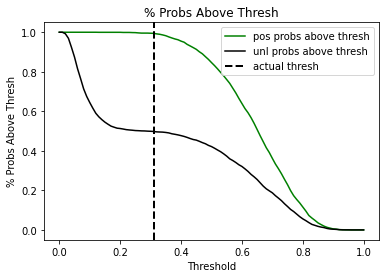

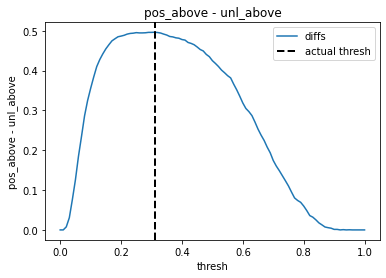

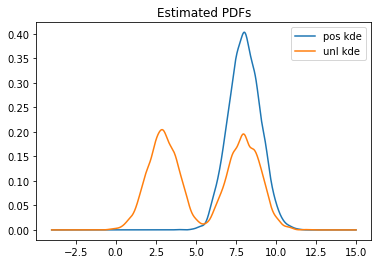

In [35]:
experiment_single(pos_mu = 8, neg_mu = 3, total_size = 6000, beta = 0.5, alpha=0.5)

## O(n) Algorithm
The basic idea is that instead of using all of the probabilities to find the optimal threshold, bin the probabilities as they come.

In [94]:
pos_mu = 8
neg_mu = 3
total_size = 4000
beta = 0.5
alpha=0.7

pos_size = int(beta*total_size)
unl_size = int(total_size - pos_size)

X_train, y_train ,_,_ = get_data(pos_mu=pos_mu, neg_mu=neg_mu, pos_size=pos_size, unl_size=unl_size, alpha=alpha)

clf = train_NTC(X_train, y_train)

_, _, pos_test, unl_test = get_data(pos_mu=pos_mu, neg_mu=neg_mu, pos_size=pos_size, unl_size=unl_size, alpha=alpha)

data_stream = np.concatenate((pos_test, unl_test))
labels = np.concatenate((np.zeros_like(pos_test),np.ones_like(unl_test)))

# Shuffle Data
p = np.random.permutation(len(labels))
data_stream = data_stream[p]
labels = labels[p]

stream = np.column_stack((data_stream,labels))

bins = np.linspace(0.1, 1, 10)

pos_bins = np.zeros_like(bins)
unl_bins = np.zeros_like(bins)

p_count = 1
n_count = 1 # init to 1 to avoid division by 0

loEst = []
lot = []

unl_probs = []
pos_probs = []
    
for value in stream:
    
    # make prediction
    prob = clf.predict_proba([[value[0]]])[0][0]
    
    # find index of bin for prob, O(10) since there are 10 bins
    idx = int(np.digitize([prob], bins, right=False))
    
    if math.isclose(value[1], 0): # Positive sample
        pos_bins[idx] += 1
        pos_probs.append(prob)
        
    else: # Unlabeled sample
        unl_bins[idx] += 1
        unl_probs.append(prob)
    
    # Find opt thresh O(((binsChoose2)*bins) because i goes from bins-1 to 1
    difs = []

    for i in range(1,len(bins)):
        
        if (pos_bins.sum() > 0) and (unl_bins.sum() > 0):
            
            pos_above = (pos_bins[range(i, len(bins))].sum())/pos_bins.sum()
            unl_above = (unl_bins[range(i, len(bins))].sum())/unl_bins.sum()
    
            difs.append(pos_above-unl_above) # Need abs?

        else:
            difs.append(0)
        
    max_dif_idx = np.argmax(difs)
    opt_thresh = bins[max_dif_idx]
    lot.append(opt_thresh)
    
    # update MPE
    
    if math.isclose(value[1], 1):
        if prob > opt_thresh:
        #if prob > 0.3:
            p_count += 1

        else:
            n_count += 1

        alpha_estimate = (p_count)/(p_count+n_count)

        loEst.append(alpha_estimate)
    
final_estimate = loEst[-1]

print(f'Alpha estimate: {final_estimate}')

Alpha estimate: 0.6948051948051948


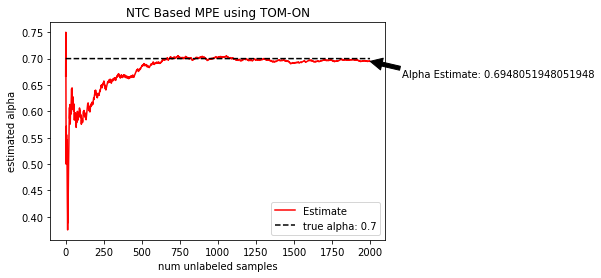

In [101]:
plot_MPE(loEst, alpha)

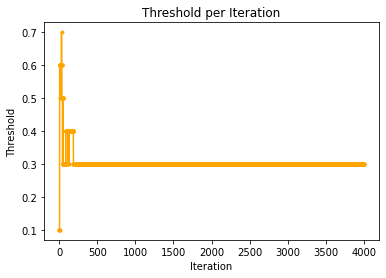

In [96]:
plot_thresh(lot)


   Threshold in the first 250 iterations


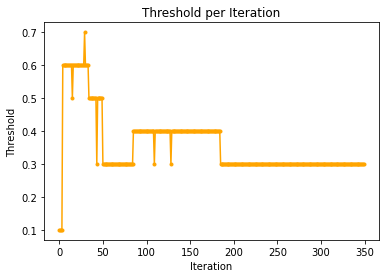

In [97]:
print()
print("   Threshold in the first 250 iterations")
lot250=lot[0:350]
plot_thresh(lot250)
plt.show()

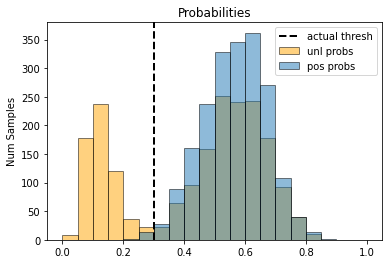

In [85]:
plot_probs(unl_probs, pos_probs, lot[-1])